## Post Sentiment Classification Task

In [3]:
import pandas as pd
import numpy as np

train_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_train.json")

validation_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_validation.json")

test_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_test.json")

In [4]:
# Your code here
train_data.head(5)

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity
0,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7f317,https://www.reddit.com/r/relationships/comment...,Melodrama_,"It's a sad realization, isn't it?",,False,2,t1_cy7erc5,negative,1.000000
1,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hlyf,https://www.reddit.com/r/relationships/comment...,Melodrama_,I told her a couple of minutes ago that I didn...,elaboration,False,2,t1_cy7erc5,neutral,0.483631
2,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7etrr,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Leeches don't make good friends.,answer,False,1,t3_3xshx9,positive,0.600000
3,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hhpq,https://www.reddit.com/r/relationships/comment...,Melodrama_,I just ended it. Apparently she wasn't a good ...,elaboration,False,2,t1_cy7etrr,positive,0.475000
4,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7q0qg,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Good for you! Make sure you stick with it.,appreciation,False,3,t1_cy7hhpq,positive,0.744444


In [5]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

#all_stopwords = nlp.Defaults.stop_words

('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f0dbac94de0>)

In [6]:
#Tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    #if(not token.text in all_stopwords): # Remove stop words in token process
    tokens.append(token)
  return tokens

#Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens

#Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

In [7]:
ex_sen = train_data['body'][0]
tokenize_normalize(ex_sen)

['it', 'a', 'sad', 'realization', 'is', 'it']

In [8]:
label_val = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
for val in label_val:
  print('Training set with ['+val+']: %.1f%%' % (100*sum(train_data['sentiment.polarity'] == val)/len(train_data)))

for val in label_val: 
  print('Validation set with ['+val+']: %.1f%%' %  ((100*sum(validation_data['sentiment.polarity'] == val)/len(validation_data))))

for val in label_val:  
  print('Test set with ['+val+']: %.1f%%' % (100*sum(test_data['sentiment.polarity'] == val)/len(test_data)))

Training set with [very negative]: 0.8%
Training set with [negative]: 7.2%
Training set with [neutral]: 63.3%
Training set with [positive]: 26.6%
Training set with [very positive]: 2.1%
Validation set with [very negative]: 0.5%
Validation set with [negative]: 6.9%
Validation set with [neutral]: 63.1%
Validation set with [positive]: 27.2%
Validation set with [very positive]: 2.3%
Test set with [very negative]: 0.8%
Test set with [negative]: 7.0%
Test set with [neutral]: 62.6%
Test set with [positive]: 27.4%
Test set with [very positive]: 2.1%


In [9]:
import collections

label_counts = collections.Counter(train_data['sentiment.polarity'])

for label in label_counts:
  print("class: " + str(label))
  print(label_counts[label] / len(train_data))

class: negative
0.07233481627945296
class: neutral
0.6326412918108419
class: positive
0.2661888284725655
class: very positive
0.02084363157027517
class: very negative
0.007991431866864393


In [10]:
def create_label(x):
  if x == "very negative":
    return 0
  elif x == "negative":
    return 1
  elif x == "neutral":
    return 2
  elif x == "positive":
    return 3
  elif x == "very positive":
    return 4

In [11]:
train_data['Class'] = train_data['sentiment.polarity'].apply(create_label)
validation_data['Class'] = validation_data['sentiment.polarity'].apply(create_label)
test_data['Class'] = test_data['sentiment.polarity'].apply(create_label)

In [12]:
train_labels = train_data['Class']
validation_labels = validation_data['Class']
test_labels = test_data['Class']

In [13]:
apply_label_counts = collections.Counter(train_data['Class'])

for label in apply_label_counts:
  print("class: " + str(label))
  print(apply_label_counts[label] / len(train_data))

class: 1
0.07233481627945296
class: 2
0.6326412918108419
class: 3
0.2661888284725655
class: 4
0.02084363157027517
class: 0
0.007991431866864393


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

one_hot_vectorizer = CountVectorizer(tokenizer=tokenize_normalize, binary=True)
train_features = one_hot_vectorizer.fit_transform(train_data['body'])

validation_features = one_hot_vectorizer.transform(validation_data['body'])
test_features = one_hot_vectorizer.transform(test_data['body'])

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary_macro(description, predictions, true_labels):
  print("Evaluation(macro) for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  #print(classification_report(predictions, true_labels, digits=3, zero_division = 0))
  return description,accuracy,precision,recall,f1

def evaluation_summary_weighted(description, predictions, true_labels):
  print("Evaluation(weighted) for: " + description)
  precision = precision_score(predictions, true_labels, average='weighted')
  recall = recall_score(predictions, true_labels, average='weighted')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='weighted') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3, zero_division = 0))
  return description,accuracy,precision,recall,f1

# **Q1 Explor Classifier Models**

In [14]:
# Dummy Classifier
from sklearn.dummy import DummyClassifier

overall_result_macro = list()
overall_result_weighted = list()

dummy_mf = DummyClassifier(strategy='most_frequent')
dummy_mf.fit(train_features, train_labels)
overall_result_macro.append(evaluation_summary_macro("Dummy Majority", dummy_mf.predict(test_features), test_labels))
overall_result_weighted.append(evaluation_summary_weighted("Dummy Majority", dummy_mf.predict(test_features), test_labels))

dummy_prior = DummyClassifier(strategy='stratified')
dummy_prior.fit(train_features, train_labels)
overall_result_macro.append(evaluation_summary_macro("Dummy Prior", dummy_prior.predict(test_features), test_labels))
overall_result_weighted.append(evaluation_summary_weighted("Dummy Prior", dummy_prior.predict(test_features), test_labels))

Evaluation(macro) for: Dummy Majority
Classifier 'Dummy Majority' has Acc=0.626 P=0.200 R=0.125 F1=0.154
Evaluation(weighted) for: Dummy Majority
Classifier 'Dummy Majority' has Acc=0.626 P=1.000 R=0.626 F1=0.770
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.000     0.000     0.000         0
           2      1.000     0.626     0.770      4016
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0

    accuracy                          0.626      4016
   macro avg      0.200     0.125     0.154      4016
weighted avg      1.000     0.626     0.770      4016

Evaluation(macro) for: Dummy Prior
Classifier 'Dummy Prior' has Acc=0.467 P=0.195 R=0.195 F1=0.195
Evaluation(weighted) for: Dummy Prior
Classifier 'Dummy Prior' has Acc=0.466 P=0.460 R=0.466 F1=0.463
              precision    recall  f1-score   support

           0      0.000     0.000     0.00

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Logistic Regression one-hot
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 1000)
lr_model = lr.fit(train_features, train_labels)
overall_result_macro.append(evaluation_summary_macro("LR onehot", lr_model.predict(test_features), test_labels))
overall_result_weighted.append(evaluation_summary_weighted("LR onehot", lr_model.predict(test_features), test_labels))

Evaluation(macro) for: LR onehot
Classifier 'LR onehot' has Acc=0.748 P=0.439 R=0.633 F1=0.486
Evaluation(weighted) for: LR onehot
Classifier 'LR onehot' has Acc=0.748 P=0.786 R=0.748 F1=0.762
              precision    recall  f1-score   support

           0      0.156     0.714     0.256         7
           1      0.248     0.483     0.328       145
           2      0.877     0.778     0.825      2834
           3      0.633     0.712     0.671       980
           4      0.279     0.480     0.353        50

    accuracy                          0.748      4016
   macro avg      0.439     0.633     0.486      4016
weighted avg      0.786     0.748     0.762      4016



In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Logistic Regression tf-idf

pred_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf-idf', TfidfVectorizer(tokenizer = tokenize_normalize)),
              ('logreg', LogisticRegression(max_iter=1000))
              ])

pred_pipeline.fit(train_data, train_labels)

Pipeline(memory=None,
         steps=[('selector', ItemSelector(key='body')),
                ('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize_normalize at 0x7f93e715c0e0>,
                                 use_idf=True, vocabulary=None)),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                         

In [18]:
overall_result_macro.append(evaluation_summary_macro("LR TFIDF", pred_pipeline.predict(test_data), test_labels))  
overall_result_weighted.append(evaluation_summary_weighted("LR TFIDF", pred_pipeline.predict(test_data), test_labels))  

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.741 P=0.331 R=0.588 F1=0.357


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation(weighted) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.741 P=0.853 R=0.741 F1=0.780
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.089     0.625     0.155        40
           2      0.944     0.738     0.829      3212
           3      0.517     0.757     0.615       753
           4      0.105     0.818     0.186        11

    accuracy                          0.741      4016
   macro avg      0.331     0.588     0.357      4016
weighted avg      0.853     0.741     0.780      4016



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# SVC Classifier

from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(train_features, train_labels)
overall_result_macro.append(evaluation_summary_macro("SVC", svm.predict(test_features), test_labels))
overall_result_weighted.append(evaluation_summary_weighted("SVC", svm.predict(test_features), test_labels))

Evaluation(macro) for: SVC
Classifier 'SVC' has Acc=0.730 P=0.288 R=0.458 F1=0.287


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation(weighted) for: SVC
Classifier 'SVC' has Acc=0.730 P=0.875 R=0.730 F1=0.782
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.014     0.800     0.028         5
           2      0.958     0.721     0.823      3339
           3      0.470     0.771     0.584       672
           4      0.000     0.000     0.000         0

    accuracy                          0.730      4016
   macro avg      0.288     0.458     0.287      4016
weighted avg      0.875     0.730     0.782      4016



In [20]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=1000, random_state=0)
RF.fit(train_features, train_labels)
overall_result_macro.append(evaluation_summary_macro("Random Forest", RF.predict(test_features), test_labels))   
overall_result_weighted.append(evaluation_summary_weighted("Random Forest", RF.predict(test_features), test_labels))   

Evaluation(macro) for: Random Forest
Classifier 'Random Forest' has Acc=0.724 P=0.341 R=0.810 F1=0.385
Evaluation(weighted) for: Random Forest
Classifier 'Random Forest' has Acc=0.724 P=0.881 R=0.724 F1=0.774
              precision    recall  f1-score   support

           0      0.094     1.000     0.171         3
           1      0.060     0.895     0.113        19
           2      0.969     0.711     0.820      3424
           3      0.397     0.802     0.531       545
           4      0.186     0.640     0.288        25

    accuracy                          0.724      4016
   macro avg      0.341     0.810     0.385      4016
weighted avg      0.881     0.724     0.774      4016



In [21]:
# Macro Score compare table

column_result_name = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1']
df_result_macro = pd.DataFrame(overall_result_macro, columns=column_result_name)

pd.set_option("display.precision", 3)

print("Macro Score Table")

def highlight_bestperformance(row):

  if(row.F1 == df_result_macro['F1'].max()):
    return ['background-color: yellow']*5
  else:
    return ['background-color: white']*5

df_result_macro.style.apply(highlight_bestperformance, axis=1)

Macro Score Table


,Classifier,Accuracy,Precision,Recall,F1
0,Dummy Majority,0.626,0.200,0.125,0.154
1,Dummy Prior,0.467,0.195,0.195,0.195
2,LR onehot,0.748,0.439,0.633,0.486
3,LR TFIDF,0.741,0.331,0.588,0.357
4,SVC,0.730,0.288,0.458,0.287
5,Random Forest,0.724,0.341,0.810,0.385


Macro Score Bar


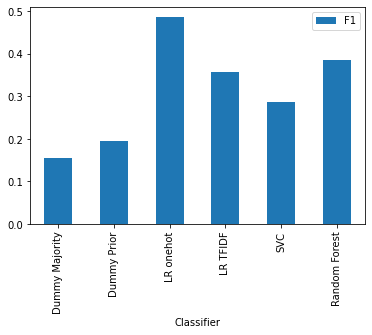

In [22]:
print("Macro Score Bar")
ax = df_result_macro.plot.bar(x='Classifier', y='F1')

In [23]:
# Weighted Score compare table

df_result_weighted = pd.DataFrame(overall_result_weighted, columns=column_result_name)

print("Weighted Score Table")

def highlight_bestperformance(row):

  if(row.F1 == df_result_weighted['F1'].max()):
    return ['background-color: yellow']*5
  else:
    return ['background-color: white']*5

df_result_weighted.style.apply(highlight_bestperformance, axis=1)

Weighted Score Table


,Classifier,Accuracy,Precision,Recall,F1
0,Dummy Majority,0.626,1.000,0.626,0.770
1,Dummy Prior,0.466,0.460,0.466,0.463
2,LR onehot,0.748,0.786,0.748,0.762
3,LR TFIDF,0.741,0.853,0.741,0.780
4,SVC,0.730,0.875,0.730,0.782
5,Random Forest,0.724,0.881,0.724,0.774


Weighted Score Bar


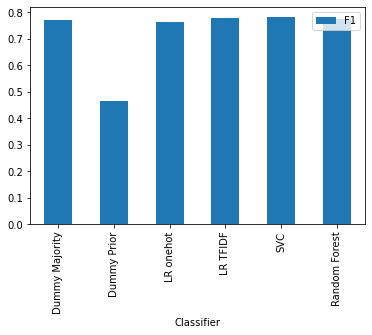

In [24]:
print("Weighted Score Bar")
ax = df_result_weighted.plot.bar(x='Classifier', y='F1')

**ANS**
From the score table of all classifier that use training and test dataset, the macro score is being select for consideration than weighted as imbalance datase. Therefore, the Logistice Regression with one-hot encoding has the highest F1 score along with accuracy and precision score.

For all dataset including training, validation, and test sets, neutral class is a majority with 63 percentage while very negative and very positive class are minority with 1 and 2 percentage respectively. The positive class is 27 percentage and negative class is 7 percentage.

The tokenization and normalisations are same as previous classifier. I choose random forest classifer as it base on decision tree process selecting random sample dataset, while it perform vote for each predicted result from decision tree to find most vote as the final prediction. For vectorization form, I choose one-hot encoding(Bag of Words) as it count frequncies of term in body text that may have relation to sentiment polarity. 

While F1 performance of random forest classifier is not higher than Logistic Regression with one-hot encoding, but suprisingly macro Recall score of random forest is the highest which mean it has high rate of correct relevant result while in Precision score area is lower which decrease F1 score. Overall, random forest classifier achieve good performance higher than the baselines compare to other classifiers.

# **Q2 Parameter tunning LogisticRegression with TF-IDF vectorization**

## List of TF-IDF vectorization models with different parameters for measure logistic regression macro average score.

In [15]:
tfidf_vectorizer_1 = TfidfVectorizer(tokenizer=tokenize_normalize, sublinear_tf=True, max_features=10000, norm='l2')
tfidf_1_train_features = tfidf_vectorizer_1.fit_transform(train_data['body'])
tfidf_1_validation_features = tfidf_vectorizer_1.transform(validation_data['body'])
tfidf_1_test_features = tfidf_vectorizer_1.transform(test_data['body'])

In [28]:
tfidf_vectorizer_2 = TfidfVectorizer(tokenizer=tokenize_normalize, sublinear_tf=False, max_features=10000, norm='l2')
tfidf_2_train_features = tfidf_vectorizer_2.fit_transform(train_data['body'])
tfidf_2_validation_features = tfidf_vectorizer_2.transform(validation_data['body'])
tfidf_2_test_features = tfidf_vectorizer_2.transform(test_data['body'])

In [32]:
tfidf_vectorizer_3 = TfidfVectorizer(tokenizer=tokenize_normalize, sublinear_tf=True, max_features=25000, norm='l2')
tfidf_3_train_features = tfidf_vectorizer_3.fit_transform(train_data['body'])
tfidf_3_validation_features = tfidf_vectorizer_3.transform(validation_data['body'])
tfidf_3_test_features = tfidf_vectorizer_3.transform(test_data['body'])

In [33]:
tfidf_vectorizer_4 = TfidfVectorizer(tokenizer=tokenize_normalize, sublinear_tf=False, max_features=25000, norm='l2')
tfidf_4_train_features = tfidf_vectorizer_4.fit_transform(train_data['body'])
tfidf_4_validation_features = tfidf_vectorizer_4.transform(validation_data['body'])
tfidf_4_test_features = tfidf_vectorizer_4.transform(test_data['body'])

In [153]:
tfidf_vectorizer_5 = TfidfVectorizer(tokenizer=tokenize_normalize, sublinear_tf=True, max_features=50000, norm='l2')
tfidf_5_train_features = tfidf_vectorizer_5.fit_transform(train_data['body'])
tfidf_5_validation_features = tfidf_vectorizer_5.transform(validation_data['body'])
tfidf_5_test_features = tfidf_vectorizer_5.transform(test_data['body'])

In [175]:
tfidf_vectorizer_6 = TfidfVectorizer(tokenizer=tokenize_normalize, sublinear_tf=True, ngram_range=(1,2), max_features=50000, norm='l2')
tfidf_6_train_features = tfidf_vectorizer_6.fit_transform(train_data['body'])
tfidf_6_validation_features = tfidf_vectorizer_6.transform(validation_data['body'])
tfidf_6_test_features = tfidf_vectorizer_6.transform(test_data['body'])

## TFIDF Vectorize parameters comparison using identical parameters as baseline for logistic regression.

In [146]:
# TfidfVectorizer Model No.[1] with sublinear_tf=True, max_features=10000, norm='l2'
lr = LogisticRegression(solver='saga', C=0.0001, max_iter=1000, class_weight='balanced', tol=0.00001, random_state=0)
combined_model = lr.fit(tfidf_1_train_features,train_labels)
baseline_1 = evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_1_validation_features), validation_labels)     

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.408 P=0.570 R=0.320 F1=0.310


In [148]:
# TfidfVectorizer Model No.[2] with sublinear_tf=False, max_features=10000, norm='l2'
lr = LogisticRegression(solver='saga', C=0.0001, max_iter=1000, class_weight='balanced', tol=0.00001, random_state=0)
combined_model = lr.fit(tfidf_2_train_features,train_labels)
baseline_2 = evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_2_validation_features), validation_labels)     

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.386 P=0.553 R=0.319 F1=0.298


In [149]:
# TfidfVectorizer Model No.[3] with sublinear_tf=True, max_features=25000, norm='l2'
lr = LogisticRegression(solver='saga', C=0.0001, max_iter=1000, class_weight='balanced', tol=0.00001, random_state=0)
combined_model = lr.fit(tfidf_3_train_features,train_labels)
baseline_3 = evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_3_validation_features), validation_labels)   

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.400 P=0.557 R=0.316 F1=0.305


In [150]:
# TfidfVectorizer Model No.[4] with sublinear_tf=False, max_features=25000, norm='l2'
lr = LogisticRegression(solver='saga', C=0.0001, max_iter=1000, class_weight='balanced', tol=0.00001, random_state=0)
combined_model = lr.fit(tfidf_4_train_features,train_labels)
baseline_4 = evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_4_validation_features), validation_labels)     

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.377 P=0.539 R=0.315 F1=0.292


From the result, TfidfVectorizer models with 10000 and 25000 max_features that setting sulinear_tf parameter as True, both have slighty higher F1 score to their counterpart which set sulinear_tf parameter as False.

In [174]:
# TfidfVectorizer Model No.[5] with sublinear_tf=True, max_features=50000, norm='l2'
lr = LogisticRegression(solver='saga', C=0.0001, max_iter=1000, class_weight='balanced', tol=0.00001, random_state=0)
combined_model = lr.fit(tfidf_5_train_features,train_labels)
baseline_5 = evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_5_validation_features), validation_labels)     

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.400 P=0.557 R=0.316 F1=0.305


From the result compare to model no.3, increase in max_features doesn't affect in overall score.

In [199]:
# TfidfVectorizer Model No.[6] with sublinear_tf=True, max_features=50000, norm='l2', ngram_range=(1,2)
lr = LogisticRegression(solver='saga', C=0.0001, max_iter=1000, class_weight='balanced', tol=0.00001, random_state=0)
combined_model = lr.fit(tfidf_6_train_features,train_labels)
baseline_6 = evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_6_validation_features), validation_labels)     

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.453 P=0.569 R=0.333 F1=0.338


From the result, add ngram_range(1,2) increase overall macro average score.

## Using hyperopt in tunning parameters of Logistic Regression

In [16]:
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
N_FOLDS = 10
MAX_EVALS = 100
def objective(params, n_folds = N_FOLDS):
    """Objective function for Logistic Regression Hyperparameter Tuning"""
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC
    clf = LogisticRegression(**params, random_state=0, verbose=0)
    scores = cross_val_score(clf, obj_features, obj_labels, cv=5, scoring='f1_macro')
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    loss = 1 - best_score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [17]:
param = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'tol' : hp.uniform('tol', 0.00001, 0.0001),
    'C' : hp.uniform('C', 0.00001, 0.001),
    'solver' : hp.choice('solver', ['lbfgs', 'liblinear', 'saga']),
    'max_iter' : hp.choice('max_iter', range(1000,5000))
}

In [178]:
# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()
obj_features = tfidf_1_train_features
obj_labels = train_labels

# Optimize
best = fmin(fn = objective, space = param, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

# Sort the trials with lowest loss
bayes_trials_results_1 = sorted(bayes_trials.results, key = lambda x: x['loss'])

100%|██████████| 100/100 [09:55<00:00,  5.95s/it, best loss: 0.6592240484315345]


In [215]:
# copy best param
c = bayes_trials_results_1[0]['params']['C']
class_weight = bayes_trials_results_1[0]['params']['class_weight']
max_iter = bayes_trials_results_1[0]['params']['max_iter']
solver = bayes_trials_results_1[0]['params']['solver']
tol = bayes_trials_results_1[0]['params']['tol']

bayes_trials_results_1[:2]

[{'loss': 0.6592240484315345,
  'params': {'C': 0.0004376682362359418,
   'class_weight': 'balanced',
   'max_iter': 4850,
   'solver': 'saga',
   'tol': 6.909011482955788e-05},
  'status': 'ok'},
 {'loss': 0.6592240484315345,
  'params': {'C': 0.0004344333704947679,
   'class_weight': 'balanced',
   'max_iter': 4538,
   'solver': 'saga',
   'tol': 8.515421805350227e-05},
  'status': 'ok'}]

In [180]:
# Using hyperopt for finding best parameters with validation set
lr = LogisticRegression(solver=solver, C=c, max_iter=max_iter, class_weight=class_weight, tol=tol)
combined_model = lr.fit(tfidf_1_train_features,train_labels)
opt_1 = evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_1_validation_features), validation_labels)      
evaluation_summary_weighted("LR TFIDF", lr.predict(tfidf_1_validation_features), validation_labels) 

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.439 P=0.581 R=0.341 F1=0.337
Evaluation(weighted) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.439 P=0.579 R=0.439 F1=0.421
              precision    recall  f1-score   support

           0      0.600     0.043     0.080       210
           1      0.507     0.322     0.394       339
           2      0.314     0.775     0.447       795
           3      0.678     0.425     0.523      1348
           4      0.808     0.141     0.241       417

    accuracy                          0.439      3109
   macro avg      0.581     0.341     0.337      3109
weighted avg      0.579     0.439     0.421      3109



('LR TFIDF',
 0.43936957220971373,
 0.578549314002435,
 0.43936957220971373,
 0.42149531941033697)

In [181]:
# Change class_weight parameter to see any impact
lr = LogisticRegression(solver=solver, C=c, max_iter=max_iter, class_weight=None, tol=tol)
combined_model = lr.fit(tfidf_1_train_features,train_labels)
evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_1_validation_features), validation_labels)    
evaluation_summary_weighted("LR TFIDF", lr.predict(tfidf_1_validation_features), validation_labels) 

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.631 P=0.200 R=0.126 F1=0.155
Evaluation(weighted) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.631 P=1.000 R=0.631 F1=0.774
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.000     0.000     0.000         0
           2      1.000     0.631     0.774      3109
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0

    accuracy                          0.631      3109
   macro avg      0.200     0.126     0.155      3109
weighted avg      1.000     0.631     0.774      3109



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('LR TFIDF', 0.6307494371180444, 1.0, 0.6307494371180444, 0.773570019723866)

Change class_weight parameter from 'balance' to None increase in accuracy for prediction class2(neutral) while other prediction got zero value with lowest macro F1 score.
As provided datasets have class imbalance when set parameter of class_weight to balanced help in adjust weights inversely ratio to class frequencies, so total accuracy of prediction may decrease while it increase in precison and recall score which affect in calculation of F1 score.


In [182]:
# Change C parameter
lr = LogisticRegression(solver=solver, C=0.00001, max_iter=max_iter, class_weight=class_weight, tol=tol)
combined_model = lr.fit(tfidf_1_train_features,train_labels)
evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_1_validation_features), validation_labels)    

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.166 P=0.344 R=0.336 F1=0.188


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('LR TFIDF',
 0.1659697651978128,
 0.3439202298750906,
 0.3356830865896156,
 0.18838045477142806)

In [183]:
# Change solver parameter
lr = LogisticRegression(solver='lbfgs', C=c, max_iter=max_iter, class_weight=class_weight, tol=tol)
combined_model = lr.fit(tfidf_1_train_features,train_labels)
evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_1_validation_features), validation_labels)    

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.419 P=0.572 R=0.335 F1=0.322


('LR TFIDF',
 0.4187841749758765,
 0.5719548298232033,
 0.33491012654558083,
 0.321720498106857)

In [184]:
# Change tol parameter
lr = LogisticRegression(solver=solver, C=c, max_iter=max_iter, class_weight=class_weight, tol=0.001)
combined_model = lr.fit(tfidf_1_train_features,train_labels)
evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_1_validation_features), validation_labels)    

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.423 P=0.574 R=0.334 F1=0.325


('LR TFIDF',
 0.4232872306207784,
 0.5744803117559827,
 0.3342765772702036,
 0.3246714787260212)

Change tol parameter seem doesn't help in increase or decrease overall score.

## Use tunning parameters of TF-IDF vectorization and Logistic Regression with hyperopt to acquire best parameters

In [176]:
tpe_algorithm = tpe.suggest
bayes_trials = Trials()
obj_features = tfidf_6_train_features
obj_labels = train_labels
best = fmin(fn = objective, space = param, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)
bayes_trials_results_6 = sorted(bayes_trials.results, key = lambda x: x['loss'])

100%|██████████| 100/100 [24:58<00:00, 14.99s/it, best loss: 0.5605891784197127]


In [232]:
# copy best param
c = bayes_trials_results_6[0]['params']['C']
class_weight = bayes_trials_results_6[0]['params']['class_weight']
max_iter = bayes_trials_results_6[0]['params']['max_iter']
solver = bayes_trials_results_6[0]['params']['solver']
tol = bayes_trials_results_6[0]['params']['tol']

bayes_trials_results_6[:2]

[{'loss': 0.5605891784197127,
  'params': {'C': 0.0007021140238796471,
   'class_weight': 'balanced',
   'max_iter': 4789,
   'solver': 'saga',
   'tol': 9.497511123379755e-05},
  'status': 'ok'},
 {'loss': 0.5605891784197127,
  'params': {'C': 0.0006968945194363242,
   'class_weight': 'balanced',
   'max_iter': 3169,
   'solver': 'saga',
   'tol': 5.671247831211894e-05},
  'status': 'ok'}]

In [274]:
# Using best parameters to check with testing set
lr = LogisticRegression(solver=solver, C=c, max_iter=max_iter, class_weight=class_weight, tol=tol, random_state=10)
combined_model = lr.fit(tfidf_6_train_features,train_labels)
test_6 = evaluation_summary_macro("LR TFIDF", lr.predict(tfidf_6_test_features), test_labels)      
evaluation_summary_weighted("LR TFIDF", lr.predict(tfidf_6_test_features), test_labels) 

Evaluation(macro) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.474 P=0.549 R=0.364 F1=0.379
Evaluation(weighted) for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.474 P=0.564 R=0.474 F1=0.458
              precision    recall  f1-score   support

           0      0.562     0.222     0.319        81
           1      0.521     0.261     0.348       564
           2      0.362     0.781     0.495      1166
           3      0.704     0.442     0.543      1755
           4      0.593     0.113     0.190       450

    accuracy                          0.474      4016
   macro avg      0.549     0.364     0.379      4016
weighted avg      0.564     0.474     0.458      4016



('LR TFIDF',
 0.4738545816733068,
 0.5639375001399566,
 0.4738545816733068,
 0.45769423441398566)

LogisticRegression with TF-IDF vectorization with default setting from Q1 has macro average score.

Accuracy=0.741 Precision=0.331 Recall=0.588 F1=0.357 as baseline score.

Model No.6 have macro average F1 score higher than baseline score of Q1 model.

Model No.6: Accuracy=0.474 Precision=0.549 Recall=0.364 F1=0.379  


Q3 Add two features

Find alternative option to increase overall score by using stopwords.

In [34]:
tfidf_vectorizer_q1_stop = TfidfVectorizer(tokenizer=tokenize_normalize_stopwords)
tfidf_q1_train_features = tfidf_vectorizer_q1_stop.fit_transform(train_data['body'])
tfidf_q1_validation_features = tfidf_vectorizer_q1_stop.transform(validation_data['body'])
tfidf_q1_test_features = tfidf_vectorizer_q1_stop.transform(test_data['body'])

In [36]:
# Using hyperopt for finding best parameters
lr = LogisticRegression(max_iter=1000)
combined_model = lr.fit(tfidf_q1_train_features,train_labels)
q1_stop = evaluation_summary_macro("LR TFIDF stopwords", lr.predict(tfidf_q1_test_features), test_labels)      
evaluation_summary_weighted("LR TFIDF stopwords", lr.predict(tfidf_q1_test_features), test_labels) 

Evaluation(macro) for: LR TFIDF stopwords
Classifier 'LR TFIDF stopwords' has Acc=0.729 P=0.316 R=0.562 F1=0.335
Evaluation(weighted) for: LR TFIDF stopwords
Classifier 'LR TFIDF stopwords' has Acc=0.729 P=0.842 R=0.729 F1=0.769
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.089     0.641     0.156        39
           2      0.934     0.731     0.820      3211
           3      0.499     0.725     0.591       759
           4      0.058     0.714     0.108         7

    accuracy                          0.729      4016
   macro avg      0.316     0.562     0.335      4016
weighted avg      0.842     0.729     0.769      4016



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('LR TFIDF stopwords',
 0.7290836653386454,
 0.8420449713689737,
 0.7290836653386454,
 0.7692526228865241)

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

all_stopwords = stopwords.words('english')
#Tokenize
def spacy_tokenize_stopwords(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    if(not token.text in all_stopwords): # Remove stop words in token process
      tokens.append(token)
  return tokens

#Normalize
def normalize_stopwords(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens

#Tokenize and normalize
def tokenize_normalize_stopwords(string):
  return normalize_stopwords(spacy_tokenize_stopwords(string))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
tfidf_vectorizer_stopw = TfidfVectorizer(tokenizer=tokenize_normalize_stopwords, 
                                     sublinear_tf=True, ngram_range=(1,2), 
                                     max_features=25000, norm='l2')
tfidf_stopw_train_features = tfidf_vectorizer_stopw.fit_transform(train_data['body'])
tfidf_stopw_validation_features = tfidf_vectorizer_stopw.transform(validation_data['body'])
tfidf_stopw_test_features = tfidf_vectorizer_stopw.transform(test_data['body'])

In [22]:
tpe_algorithm = tpe.suggest
bayes_trials = Trials()
obj_features = tfidf_stopw_train_features
obj_labels = train_labels
best = fmin(fn = objective, space = param, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)
bayes_trials_results_stopw = sorted(bayes_trials.results, key = lambda x: x['loss'])

100%|██████████| 100/100 [12:37<00:00,  7.58s/it, best loss: 0.5203389299144874]


In [23]:
# copy best param
c = bayes_trials_results_stopw[0]['params']['C']
class_weight = bayes_trials_results_stopw[0]['params']['class_weight']
max_iter = bayes_trials_results_stopw[0]['params']['max_iter']
solver = bayes_trials_results_stopw[0]['params']['solver']
tol = bayes_trials_results_stopw[0]['params']['tol']

bayes_trials_results_stopw[:2]

[{'loss': 0.5203389299144874,
  'params': {'C': 0.0005435852150591212,
   'class_weight': 'balanced',
   'max_iter': 1407,
   'solver': 'saga',
   'tol': 9.997269802219947e-05},
  'status': 'ok'},
 {'loss': 0.5203389299144874,
  'params': {'C': 0.0005443998543062312,
   'class_weight': 'balanced',
   'max_iter': 4487,
   'solver': 'saga',
   'tol': 9.164387312463808e-05},
  'status': 'ok'}]

In [34]:
# Using hyperopt with stopwords for finding best parameters
lr = LogisticRegression(solver=solver, C=c, max_iter=max_iter, class_weight=class_weight, tol=tol, random_state=40)
combined_model = lr.fit(tfidf_stopw_train_features,train_labels)
opt_stopw = evaluation_summary_macro("LR TFIDF tunning+stopwords", lr.predict(tfidf_stopw_test_features), test_labels)      
evaluation_summary_weighted("LR TFIDF tunning+stopwords", lr.predict(tfidf_stopw_test_features), test_labels) 

Evaluation(macro) for: LR TFIDF tunning+stopwords
Classifier 'LR TFIDF tunning+stopwords' has Acc=0.611 P=0.605 R=0.411 F1=0.450
Evaluation(weighted) for: LR TFIDF tunning+stopwords
Classifier 'LR TFIDF tunning+stopwords' has Acc=0.611 P=0.612 R=0.611 F1=0.589
              precision    recall  f1-score   support

           0      0.656     0.142     0.233       148
           1      0.543     0.321     0.404       476
           2      0.599     0.817     0.691      1842
           3      0.657     0.540     0.593      1340
           4      0.570     0.233     0.331       210

    accuracy                          0.611      4016
   macro avg      0.605     0.411     0.450      4016
weighted avg      0.612     0.611     0.589      4016



('LR TFIDF tunning+stopwords',
 0.6105577689243028,
 0.612077512175073,
 0.6105577689243028,
 0.588546861984038)

Model that apply stopwords in tokenization acheive higher than previous one 

Accuracy=0.611 Precision=0.605 Recall=0.411 F1=0.450

# **Q3 Adding Features**

In [100]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('tagsets')

all_stopwords = stopwords.words('english')

#Tokenize
def spacy_tokenize_postag(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    if(not token.text in all_stopwords): # Remove stop words in token process
      tokens.append(token)
  return tokens

#Normalize
def normalize_postag(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  norm_tag = nltk.pos_tag(normalized_tokens) # Part of speech tagging
  
  return [tag[1] for tag in norm_tag]

#Tokenize and normalize
def tokenize_normalize_postag(string):
  return ' '.join(normalize_postag(spacy_tokenize_postag(string)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [94]:
tokenize_normalize_postag(ex_sen)

'PRP JJ NN'

In [101]:
train_data['postags'] = train_data['body'].apply(tokenize_normalize_postag)
validation_data['postags'] = validation_data['body'].apply(tokenize_normalize_postag)
test_data['postags'] = test_data['body'].apply(tokenize_normalize_postag)

In [224]:
train_data.head(1)

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity,Class,postags
0,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7f317,https://www.reddit.com/r/relationships/comment...,Melodrama_,"It's a sad realization, isn't it?",,False,2,t1_cy7erc5,negative,1.0,1,PRP JJ NN


In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [99]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary_macro_con(description, predictions, true_labels):
  print("Evaluation(macro) for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  #print(classification_report(predictions, true_labels, digits=3, zero_division = 0))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions)) # Note the order here is true, predicted
  return description,accuracy,precision,recall,f1

def evaluation_summary_weighted_con(description, predictions, true_labels):
  print("Evaluation(weighted) for: " + description)
  precision = precision_score(predictions, true_labels, average='weighted')
  recall = recall_score(predictions, true_labels, average='weighted')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='weighted') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3, zero_division = 0))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions)) # Note the order here is true, predicted
  return description,accuracy,precision,recall,f1

In [98]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Use Pipline with feature union adding postags features

union_pipeline = Pipeline([
          ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize_stopwords, sublinear_tf=True, 
                                         ngram_range=(1,2), max_features=25000, norm='l2')),
              ])),
            ('postags', Pipeline([
              ('selector', ItemSelector(key='postags')),
              ('tf-idf', TfidfVectorizer(sublinear_tf=True, ngram_range=(2,2))),
              ])),
          ])
          )
       ])

In [102]:
tfidf_union_train_features = union_pipeline.fit_transform(train_data)
tfidf_union_validation_features = union_pipeline.transform(validation_data)
tfidf_union_test_features = union_pipeline.transform(test_data)

In [ ]:
tpe_algorithm = tpe.suggest
bayes_trials = Trials()
obj_features = tfidf_union_train_features
obj_labels = train_labels
best = fmin(fn = objective, space = param, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)
bayes_trials_results_union = sorted(bayes_trials.results, key = lambda x: x['loss'])

In [ ]:
# copy best param
c = bayes_trials_results_union[0]['params']['C']
class_weight = bayes_trials_results_union[0]['params']['class_weight']
max_iter = bayes_trials_results_union[0]['params']['max_iter']
solver = bayes_trials_results_union[0]['params']['solver']
tol = bayes_trials_results_union[0]['params']['tol']

In [ ]:
# Using best parameters to check with testing set
lr_union = LogisticRegression(solver=solver, C=c, max_iter=max_iter, class_weight=class_weight, tol=tol, random_state=10)
combined_model = lr_union.fit(tfidf_union_train_features,train_labels)

In [ ]:
print(evaluation_summary_macro_con("LR TFIDF union feature", lr_union.predict(tfidf_union_test_features2), test_labels))
print(evaluation_summary_weighted_con("LR TFIDF union feature", lr_union.predict(tfidf_union_test_features2), test_labels))   

In [61]:
union_list_macro = list()
union_list_weighted = list()

In [221]:
union_list_macro.append(evaluation_summary_macro_con("LR TFIDF union feature", lr_union.predict(tfidf_union_test_features), test_labels))  

Evaluation(macro) for: LR TFIDF union feature
Classifier 'LR TFIDF union feature' has Acc=0.270 P=0.397 R=0.265 F1=0.203

Confusion matrix:
 [[  15    4    3    4    6]
 [  45   72   34   88   43]
 [ 331  233  306 1120  524]
 [  98   89   77  643  195]
 [   7    7    7   17   48]]


In [222]:
union_list_weighted.append(evaluation_summary_weighted_con("LR TFIDF union feature", lr_union.predict(tfidf_union_test_features), test_labels))  

Evaluation(weighted) for: LR TFIDF union feature
Classifier 'LR TFIDF union feature' has Acc=0.270 P=0.482 R=0.270 F1=0.273
              precision    recall  f1-score   support

           0      0.469     0.030     0.057       496
           1      0.255     0.178     0.210       405
           2      0.122     0.717     0.208       427
           3      0.583     0.343     0.432      1872
           4      0.558     0.059     0.106       816

    accuracy                          0.270      4016
   macro avg      0.397     0.265     0.203      4016
weighted avg      0.482     0.270     0.273      4016


Confusion matrix:
 [[  15    4    3    4    6]
 [  45   72   34   88   43]
 [ 331  233  306 1120  524]
 [  98   89   77  643  195]
 [   7    7    7   17   48]]
